In [1]:
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import scipy as sp

import matplotlib.pyplot as plt

from itertools import chain

# import custom modules
sys.path.append('../utils')
import traffic_counts
import excel_calendar
import data_paths
from math import sqrt

In [2]:
# initialize Objects
cnt = traffic_counts.TrafficCounts()
cal = excel_calendar.Calendar()

road_types = cnt.road_types
vehicle_classes = cnt.vehicle_types

# import real counting data
cnt_data_path = data_paths.COUNTING_PATH + 'counting_data_combined.parquet'
cnt_data = pd.read_parquet(cnt_data_path)
cnt_data = cnt_data[cnt_data['date'].between('2019-01-01', '2019-12-31')]

# import visum links data
visum_links_path = data_paths.VISUM_FOLDER_PATH + 'visum_links.gpkg'
visum_links = gpd.read_file(visum_links_path)

scaling_road_types = {'Motorway-Nat': 'Motorway-Nat',
                        'Motorway-City': 'Motorway-Nat',
                        'TrunkRoad/Primary-National': 'Distributor/Secondary', 
                        'TrunkRoad/Primary-City': 'TrunkRoad/Primary-City',
                        'Distributor/Secondary': 'Distributor/Secondary',
                        'Local/Collector': 'Distributor/Secondary',
                        'Access-residential': 'Distributor/Secondary'}
            
visum_links['scaling_road_type'] = visum_links['road_type'].map(scaling_road_types)
visum_sum = visum_links.groupby('road_link_id').agg({'dtv_SUM': 'sum',
                                                     'scaling_road_type': lambda group: group.iloc[0]})

In [18]:
def iqr_mean(input, iqr_range =(5,95)):
    lower_bound = np.percentile(input, iqr_range[0])
    upper_bound = np.percentile(input, iqr_range[1])
    return np.mean(input[(input >= lower_bound) & (input <= upper_bound)])

def divide_no_error(a,b): 
    try:
        return a/b
    except ZeroDivisionError:
        return np.nan
    
def normal(ax, mean, std, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = sp.stats.norm.pdf(x, mean, std)
    z = ax.plot(x, p, color, linewidth=2)
    
def inter_quantile_range(input, iqr_range=(1,99)):
    lower_bound = np.percentile(input, iqr_range[0])
    upper_bound = np.percentile(input, iqr_range[1])
    return input[(input >= lower_bound) & (input <= upper_bound)]

def Serialize_cnt(df):
    cnt_ser = pd.DataFrame()
    for idx, row in df.iterrows():
        _df = pd.DataFrame(index=pd.date_range(start=idx,
                                               periods = 24,
                                               freq='1h'),
                        data = {'count': np.array(row[-24:])})
        cnt_ser = pd.concat([cnt_ser, _df])
    cnt_ser = cnt_ser.sort_index()
    return cnt_ser

def calc_sqv(Observed, Model, f=1000):
    if (Model == 0) or (Observed == 0):
        return 0
    if Model == Observed:
        return 1
    # f = 10000 is the recommended factor for daily volumes
    denominator = 1 + sqrt((pow(Model - Observed, 2)/(f * Observed)))
    return divide_no_error(1, denominator)

In [4]:
cnt_grp = cnt_data.set_index('date').groupby(['road_link_id', 'vehicle_class'])
serialized_counts = dict()

for idx, grp in cnt_grp:
    serialized_counts.update({idx:Serialize_cnt(grp)})

In [5]:
valid_road_links = cnt_data[(cnt_data['valid'])]['road_link_id'].unique()
#valid_road_links = cnt_data['road_link_id'].unique()

for id in valid_road_links:
    road_type = visum_sum.loc[id]['scaling_road_type']
    dtv = visum_sum.loc[id]['dtv_SUM']
    time_profile_scaled = dtv * cnt.timeprofile[road_type]
    #time_profile_scaled = time_profile_scaled.round()
      
    for vehicle_type in time_profile_scaled.columns:
        serialized_counts[id,vehicle_type]['profile'] = time_profile_scaled[vehicle_type]
        serialized_counts[id,vehicle_type]['diff'] =  serialized_counts[id,vehicle_type]['profile'] - serialized_counts[id,vehicle_type]['count']
        serialized_counts[id,vehicle_type]['rel_diff'] = serialized_counts[id,vehicle_type].apply(lambda row: (divide_no_error(row['diff'],
                                                                                                                                row['count']))*100, axis =1)
        serialized_counts[id,vehicle_type]['sqv'] = serialized_counts[id,vehicle_type].apply(lambda row: calc_sqv(Observed=row['count'], Model = row['profile']), axis =1)

In [6]:
def create_data_list(counts, vehicle_class, metric):
    long_lst = list()
    for id in list(set([key[0] for key in counts.keys()])): #for all road links in the counts dict
        try: 
            long_lst.append(list(counts[id,vehicle_class][metric]))
        except: 
            continue
        
    long_lst = list(chain.from_iterable(long_lst))
    long_lst = [x for x in long_lst if x == x]
    return np.array(long_lst)

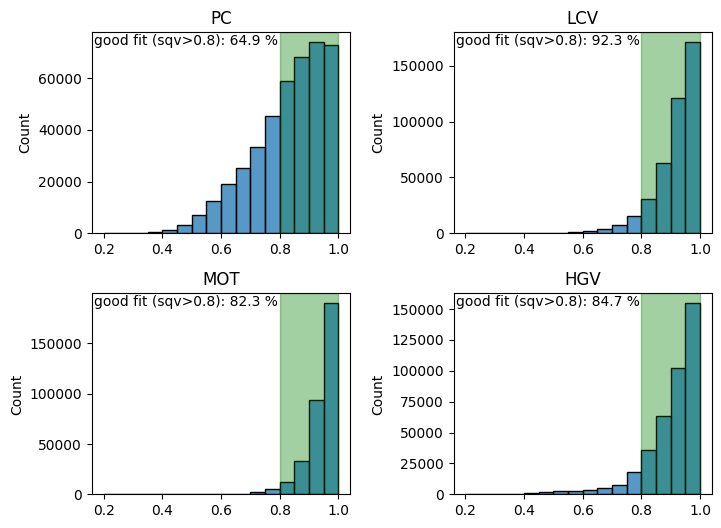

In [8]:
fig, ax = plt.subplots(2,2,figsize=(8,6))

row = 0
col = 0

for vc in ['PC','LCV','MOT','HGV']:
    data = create_data_list(serialized_counts, vc, 'sqv')
    ax[row,col].axvspan(0.8, 1, color = 'g', alpha = 0.2, zorder =0)
    sns.histplot(ax = ax[row,col], data=data, binrange =(0.2,1), bins=16)
    ax[row,col].set_title(vc)
    ax[row,col].axvspan(0.8, 1, color = 'g', alpha = 0.2)
    
    text = f'good fit (sqv>0.8): {(len(data[data>0.8])/ len(data))*100:.1f} % '
    ax[row,col].text(.01, .99, text, ha='left', va='top', transform=ax[row,col].transAxes)
    
    col+=1
    if col >= 2:
        col=0
        row +=1

plt.subplots_adjust(wspace=0.4)
plt.subplots_adjust(hspace=0.3)

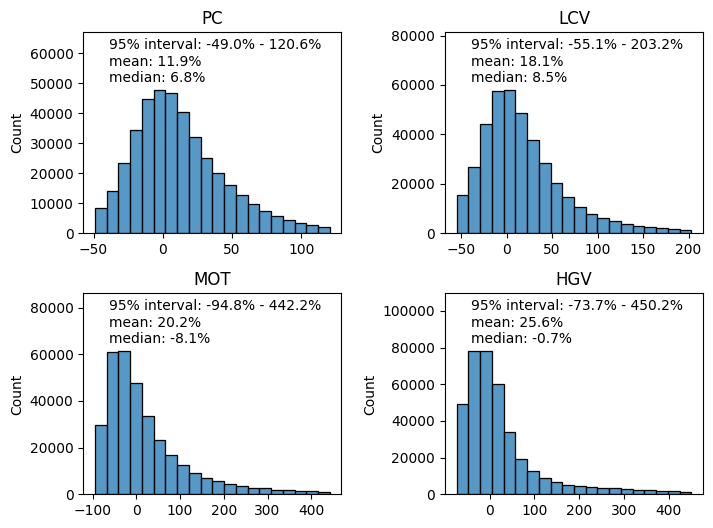

In [9]:
fig, ax = plt.subplots(2,2,figsize=(8,6))

row = 0
col = 0

for vc in ['PC','LCV','MOT','HGV']:
    data = create_data_list(serialized_counts, vc, 'rel_diff')
    data = inter_quantile_range(data, iqr_range=(2.5,97.5))
    g = sns.histplot(ax = ax[row,col], data=data, bins = 20)
    ax[row,col].set_title(vc)
    ax[row,col].set_title(vc)
    
    
    bar_heights = np.array([r.get_height() for r in g.patches])
    ax[row,col].set_ylim(0,max(bar_heights)*1.4)
    
    text = f'95% interval: {data.min():.1f}% - {data.max():.1f}%\nmean: {np.mean(data):.1f}%\nmedian: {np.median(data):.1f}%'
    ax[row,col].text(.1, .97, text, ha='left', va='top', transform=ax[row,col].transAxes)
    
    col+=1
    if col >= 2:
        col=0
        row +=1

plt.subplots_adjust(wspace=0.4)
plt.subplots_adjust(hspace=0.3)


/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_73318/2092547640.py:9: RuntimeWarning: invalid value encountered in log
  data_log = np.log(data)
/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_73318/2092547640.py:9: RuntimeWarning: invalid value encountered in log
  data_log = np.log(data)
/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_73318/2092547640.py:9: RuntimeWarning: divide by zero encountered in log
  data_log = np.log(data)
/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_73318/2092547640.py:9: RuntimeWarning: invalid value encountered in log
  data_log = np.log(data)
/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_73318/2092547640.py:9: RuntimeWarning: invalid value encountered in log
  data_log = np.log(data)


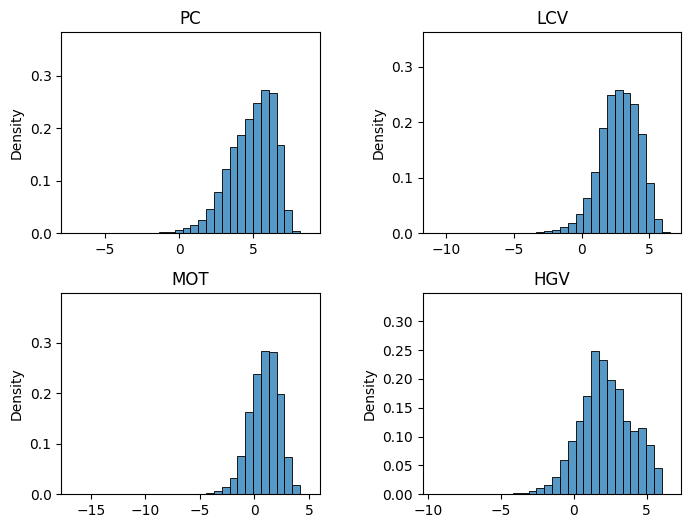

In [25]:
fig, ax = plt.subplots(2,2,figsize=(8,6))

row = 0
col = 0

for vc in ['PC','LCV','MOT','HGV']:
    data = create_data_list(serialized_counts, vc, 'diff')
    #data = inter_quantile_range(data, iqr_range=(2.5,97.5))
    data_log = np.log(data)
    g = sns.histplot(ax = ax[row,col], data=data_log, bins = 30, stat = 'density')
    normal(ax = ax[row,col], mean=data_log.mean(), std=data_log.std())
    ax[row,col].set_title(vc)
    ax[row,col].set_title(vc)
    
    
    bar_heights = np.array([r.get_height() for r in g.patches])
    ax[row,col].set_ylim(0,max(bar_heights)*1.4)
    
    #text = f'95% interval: {data.min():.1f}% - {data.max():.1f}%\nmean: {np.mean(data):.1f}%\nmedian: {np.median(data):.1f}%'
    #ax[row,col].text(.1, .97, text, ha='left', va='top', transform=ax[row,col].transAxes)
    
    col+=1
    if col >= 2:
        col=0
        row +=1

plt.subplots_adjust(wspace=0.4)
plt.subplots_adjust(hspace=0.3)


399125

In [139]:
lower_list = list()
upper_list = list()
for idx in pd.date_range(start = '2019-01-01 00:00:00',
                         end = '2019-12-31 23:00:00',
                         freq = '1h'):
    
    lst = list()
    for id in list(set([key[0] for key in serialized_counts.keys()])):
        try:
            lst.append(serialized_counts[id,'PC'].loc[idx]['rel_diff'])
        except:
            continue
    lst = [x for x in lst if x == x]
    lst_array = np.asarray(lst)
    try:
        lower_list.append(np.percentile(lst_array, 2.5))
        upper_list.append(np.percentile(lst_array, 97.5))
    except:
        print(idx)
        continue

2019-03-31 02:00:00


Text(0.5, 0, 'date')

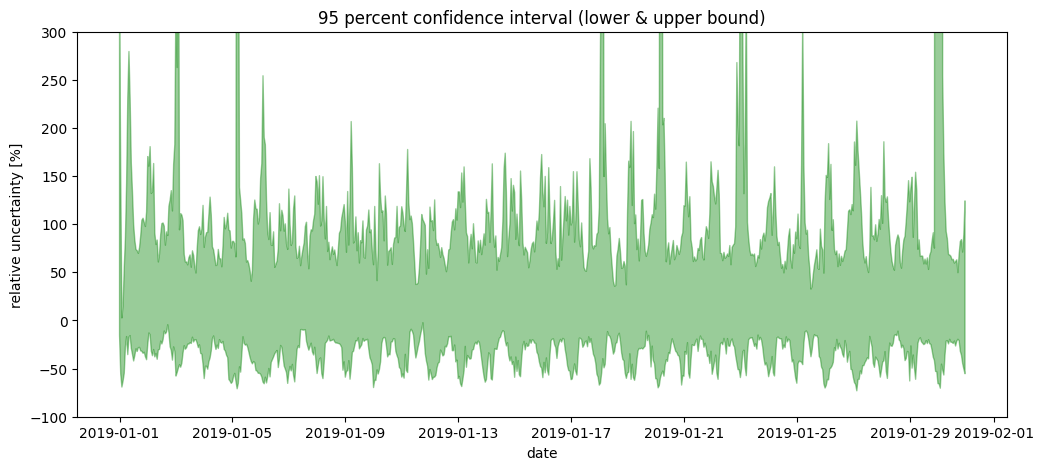

In [174]:
plt.figure(figsize= (12,5))

max_length = 720

index = pd.date_range(start = '2019-01-01 00:00:00', freq = '1h', periods=max_length)

plt.plot(data=lower_list[:max_length], index = index, color = 'blue')
plt.plot(data=upper_list[:max_length], index = index, color = 'blue')
plt.ylim(-100, 300)

plt.fill_between(x = index, y1 = lower_list[:max_length], y2=upper_list[:max_length], color = 'green', alpha = 0.4)

plt.title('95 percent confidence interval (lower & upper bound)')
plt.ylabel('relative uncertainty [%]')
plt.xlabel('date')